## Name : Fergal Keane

## Student # : 21211167

In [161]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score 
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
df = pd.read_csv("seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [70]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

### Target Values
We see that the targets are evenly spread as per the data set description

In [71]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

### Missing Values
Check below confirms that there are none

In [72]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

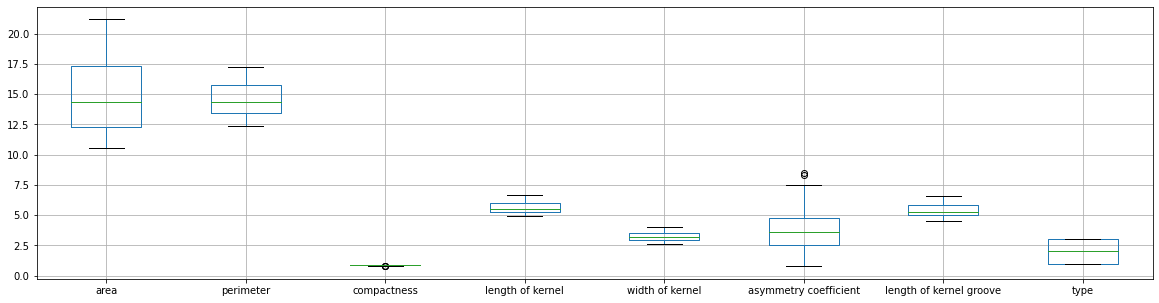

In [73]:
#df.loc[:,'radius_mean':'fractal_dimension_mean'].boxplot(figsize=(20,5))
df.boxplot(figsize=(20,5))
plt.show()

In [74]:
df.describe()

area   perimeter  compactness  length of kernel  width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       asymmetry coefficient  length of kernel groove        type  
count             210.000000               210.000000  210.000000  
mean                3.700201                 5.408071    2.000000  
std                 1.503557                 0.491480    0.818448  
min                 0.765100                 4.519000    1.000000  
25%                 2.561500                 5.045000    1.000000  
50%                 3.599000                 5.223000    2.000000  
75%                 4.768750                 5.877000    3.000000  
max                 8.456000                 6.550000    3.000000

In [75]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [76]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [77]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [78]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [289]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y)

In [290]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('svm', OneVsRestClassifier(svm.SVC(probability=True)))
])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__estimator__C': [0.1, 1, 10, 100],  
    'svm__estimator__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__estimator__kernel': ['rbf', 'linear', 'poly']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.981:
Best parameters:  {'svm__estimator__C': 10, 'svm__estimator__gamma': 1, 'svm__estimator__kernel': 'linear'}


The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.


In [291]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('rf', OneVsRestClassifier(RandomForestClassifier()))
])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__estimator__n_estimators' : [10,20,30],
    'rf__estimator__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.923:
Best parameters:  {'rf__estimator__max_depth': 4, 'rf__estimator__n_estimators': 20}


In [292]:
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('mlp', OneVsRestClassifier(MLPClassifier()))
])


param_grid = {
    'mlp__estimator__alpha':[10.0**-4, 10.0**-3,10.0**-2,10.0**-1],
    'mlp__estimator__hidden_layer_sizes': [(100,),(50,)],
    'mlp__estimator__max_iter': [1000,500],
    'mlp__estimator__activation':('relu','tanh')
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.956:
Best parameters:  {'mlp__estimator__activation': 'tanh', 'mlp__estimator__alpha': 0.0001, 'mlp__estimator__hidden_layer_sizes': (100,), 'mlp__estimator__max_iter': 1000}


In [306]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

def evaluate_model_2(X_test, y_test, model, model_name):
    '''
    my version to allow for non binary outputs
    '''
    n_classes=3 #should deduce fro munique values of type
    
    fig, axes = plt.subplots(1,2, figsize=(16,8))
    
    # compute probabilistic predictions for the evaluation set
    _probabilities = model.predict_proba(X_test)
    # compute exact predictions for the evaluation set
    _predicted_values = model.predict(X_test)
     
    #create a cross tab/confusion matrix of test v predicted
    df_conf1 = pd.crosstab(y_test, _predicted_values)
    #plot confusion matric in a heatmap to the left
    plt.subplot(121)
    sns.heatmap(df_conf1, annot=True, square=True, cmap='Blues', ax=axes[0])
    plt.title('Test versus Predicted for {0}'.format(model_name), size=20)
    plt.ylabel('Test Type')
    plt.xlabel('Predicted Type')

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
    #print(_accuracy)   

    #binary version of y_test
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
    
    # Compute ROC curve and ROC area for each class
    #plot ROC for each class to the right
    colours = ['red', 'yellow', 'green', 'brown']
    plt.subplot(122)
    #plot 'no skill' line
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='pink', label='Chance')
    
    _precision = np.zeros(n_classes)
    _recall = np.zeros(n_classes)
    _f1_score = np.zeros(n_classes)
    _support = dict()
    _fpr = dict()
    _tpr = dict()
    _xxx = dict()
    _roc_auc = dict()
    # compute precision, recall and f1 score for each class 
    for i in range(n_classes):
        # compute precision, recall and f1 score for class 1
        _precision[i], _recall[i], _f1_score[i], _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[i+1])
        _fpr[i], _tpr[i], _xxx[i] = roc_curve(y_test_bin[:, i], _probabilities[:, i])
        _roc_auc[i] = auc(_fpr[i], _tpr[i])

        axes[1].plot(_fpr[i], _tpr[i], label='ROC curve type {0} (AUC = {1:0.4f})'.format(i+1, _roc_auc[i]))

    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Receiver Operating Characteristic (ROC) Chart for {0}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()
    
           
    _weighted_auc = roc_auc_score(y_test_bin, _probabilities, multi_class="ovr", average="weighted")
    
    return _accuracy, np.mean(_precision), np.mean(_recall), np.mean(_f1_score), _weighted_auc   
    
    


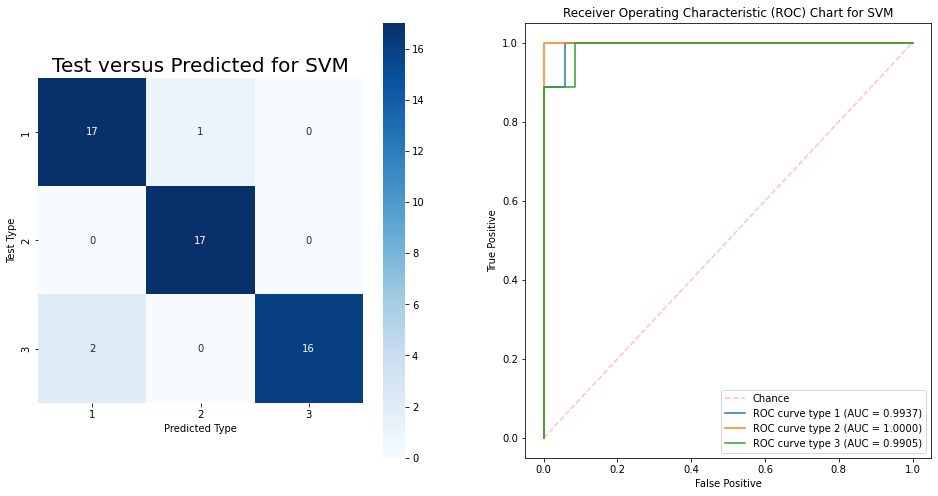

In [307]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_w_auc = evaluate_model_2(X_test, y_test, SVM_best_model, 'SVM')


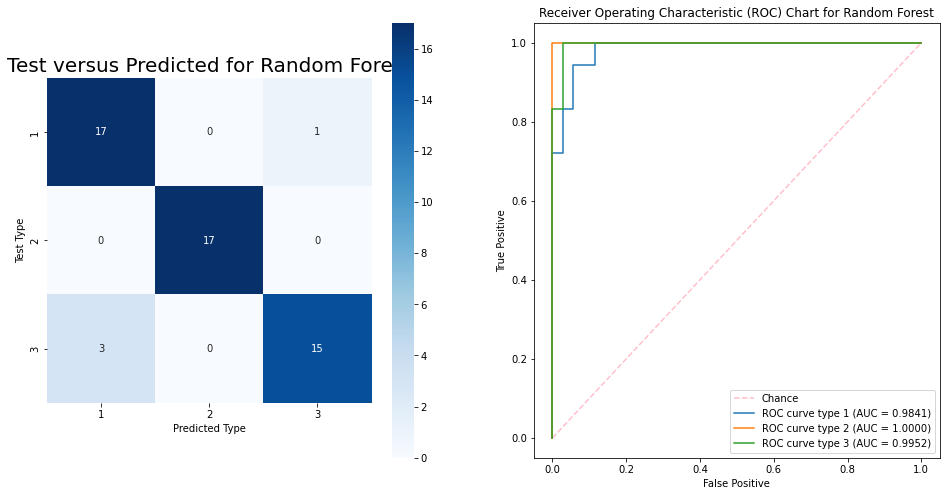

In [308]:
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_w_auc = evaluate_model_2(X_test, y_test, RF_best_model, 'Random Forest')


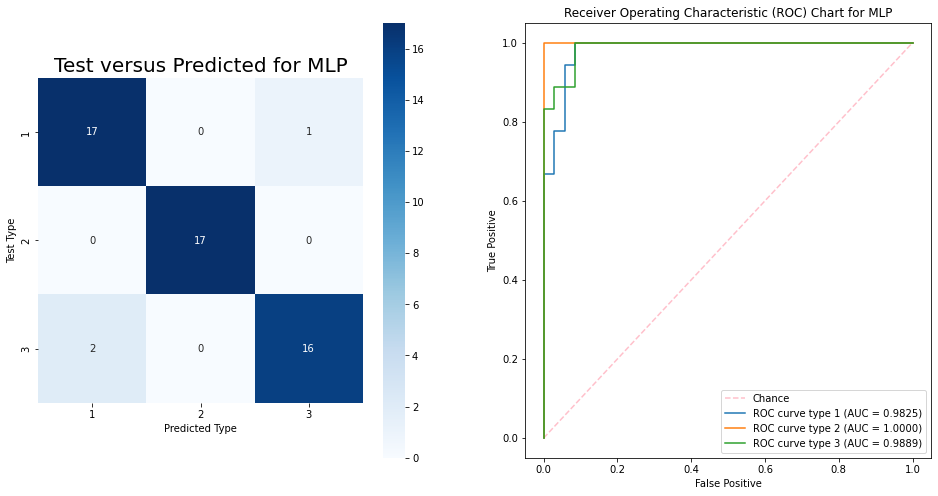

In [309]:
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_w_auc = evaluate_model_2(X_test, y_test, MLP_best_model, 'MLP')


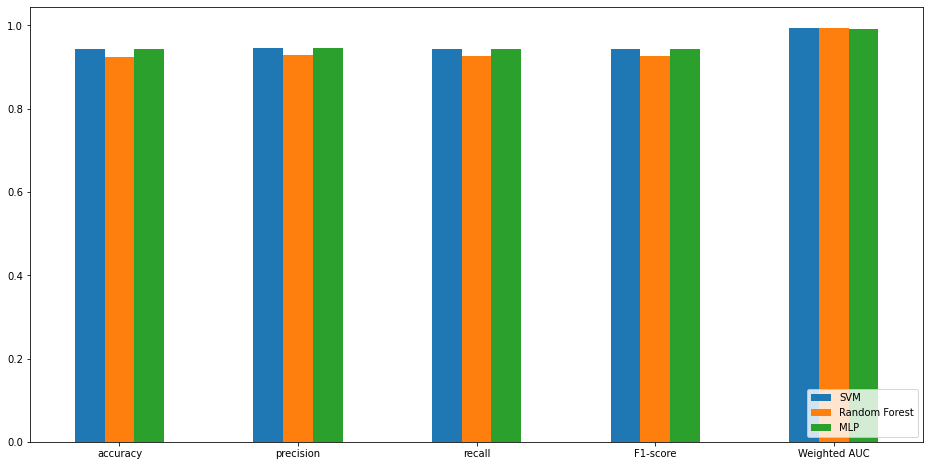

                   SVM  Random Forest       MLP
accuracy      0.943396       0.924528  0.943396
precision     0.946394       0.929167  0.945304
recall        0.944444       0.925926  0.944444
F1-score      0.943841       0.925697  0.944402
Weighted AUC  0.994609       0.992992  0.990296


In [310]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_w_auc])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_w_auc])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_w_auc])
index = ['accuracy', 'precision', 'recall', 'F1-score', 'Weighted AUC']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP' : MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0, figsize=(16,8))
plt.legend(loc="lower right")
plt.show()

print(df_metrics)

#### Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [313]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__estimator__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [314]:
filename = 'final_seeds_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Observation
Rather than assign binary values (type/not type) I tried to use the OneVsRest classifier which I believe achieves the same thing. This did complicate my coding somewhat as the metrics were calculated for each class and had to then be interpreted.

As can be seen from the confusion chart and the summary bar chart all three classifiers used (SVM, Random Forest & MLP) perform very well, with only marginal differences between them. However, SVM shades it slightly so that is the model was was selected. 